<a href="https://colab.research.google.com/github/sonuuno2020/CNN/blob/main/04_transfer_learning_in_tensorflow_(_feature_extraction_part_1_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is transfer leraning ❓**

**It is leveraging an existing model which has `proven to work` on similar problem to our problem...**
**It has already learned patterns on similar to our data.**

---

> In this notebook we are going to use **feautre extraction** technique of **transfer learning**..

In this technique we use a pretrained model which is used **as it as ( without training )** and only output layer goes in training..

Here we train our model on different dataset.

In [ ]:
!nvidia-smi # are we using GPU

Fri Jan 21 12:48:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Get Data**

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zipref=zipfile.ZipFile('10_food_classes_10_percent.zip')
zipref.extractall()
zipref.close()


--2022-01-21 12:51:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   215MB/s    in 0.7s    

2022-01-21 12:51:40 (215 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



## **Become one with data**

In [ ]:
import os

In [ ]:
for dirpath,dirname,filename in os.walk('10_food_classes_10_percent'):
  print(f"there are {len(dirname)} directories and {len(filename)} images in {dirpath}")

there are 2 directories and 0 images in 10_food_classes_10_percent
there are 10 directories and 0 images in 10_food_classes_10_percent/test
there are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
there are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
there are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
there are 10 directori

### **create data loaders**

In [ ]:
train_dir='10_food_classes_10_percent/train'
test_dir='10_food_classes_10_percent/test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("training images:")

train_data_10p=train_datagen.flow_from_directory(train_dir,
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 )
print("Testing images:")

test_data_10p=test_datagen.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               batch_size=32)

training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## **setting up callbacks**

**Callback** : extra functionality added to model,which exceute during training and after training...

popular callbacks 🐾

1. tracking training of our model by tensorboard callback
2. Model checkpoint with ModelCheckPoint callback
3. stopping model to train callback by EarlyStopping callback

In [ ]:
# create tensorboard callback for tracing model training

import datetime
 

def create_tensorboard_callback(dirname,experiment_name):

  logdir=dirname+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
  print(f"Saving Tensorboard log files to {logdir}")
  return tensorboard_callback

## **Creating models with Tensorflow_hub**

It is a collection of trained models.
https://tfhub.dev/s?module-type=image-classification


Ater browsing on above link we found a model ☢

EfficientNet 🐾 https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

ResNet 🐾 https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5



**Let's compare these 2 models**

In [ ]:
resnet_url='https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5'

efficientnet_url='https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
def creat_model(model_url,num_classes):
  """
    inputs: model url extracted from tensorflow_hub,
    num classes is number of nueron in output layer
    return: a sequential model
  """
  # download pretrained model and save it as keras layer

  feature_extractor_layer=hub.KerasLayer(model_url,
                                         trainable=False,
                                         name="feature_extractor_layer",
                                         input_shape=(224,224,3))
  model=tf.keras.models.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes,activation='softmax',name="output_layer")                                    
  ])

  return model

### **create Resnet feature extraction layer and testing it 😎**

In [ ]:
resnet_model=creat_model(resnet_url,10)

In [ ]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer='adam',
                     metrics=['accuracy'])

### **fit resnet model**



In [ ]:
resnet_history=resnet_model.fit(train_data_10p,epochs=5,
                                validation_data=test_data_10p,
                                steps_per_epoch=len(train_data_10p),
                                validation_steps=len(test_data_10p),
                                callbacks=[create_tensorboard_callback('content/records','resnet_model'),])

Saving Tensorboard log files to content/records/resnet_model/20220121-140314
Epoch 1/5
24/24 [==============================] - 37s 989ms/step - loss: 1.9640 - accuracy: 0.3627 - val_loss: 1.1960 - val_accuracy: 0.6076
Epoch 2/5
24/24 [==============================] - 20s 878ms/step - loss: 0.9090 - accuracy: 0.7480 - val_loss: 0.8394 - val_accuracy: 0.7300
Epoch 3/5
24/24 [==============================] - 20s 874ms/step - loss: 0.6095 - accuracy: 0.8307 - val_loss: 0.7429 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 21s 880ms/step - loss: 0.4680 - accuracy: 0.8707 - val_loss: 0.6803 - val_accuracy: 0.7844
Epoch 5/5
24/24 [==============================] - 21s 882ms/step - loss: 0.3495 - accuracy: 0.9267 - val_loss: 0.6449 - val_accuracy: 0.7952


Cool 😃 🤩 😎... 🔥 🎆 

This model outperfeorm to all which we make earlier ... with only 10% of data

### **Evaluate resnet model**

make a function to plot loss and accuracy curves.. 💹

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  epochs=tf.range(len(loss))

  plt.plot(epochs,loss,label="loss")
  plt.plot(epochs,val_loss,label="validation loss")
  plt.title("Loss curves")
  plt.xlabel("epochs")
  plt.legend()


In [ ]:
def plot_accuracy_curves(history):
  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=tf.range(len(accuracy))

  plt.plot(epochs,accuracy,label="accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy curves")
  plt.xlabel("epochs")
  plt.legend()

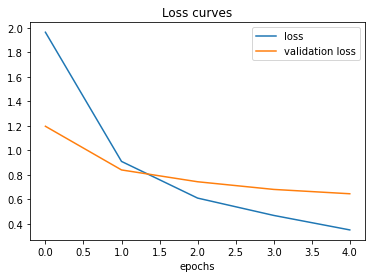

In [ ]:
plot_loss_curves(resnet_history)

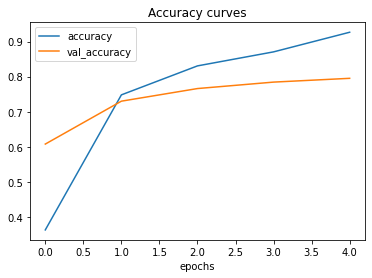

In [ ]:
plot_accuracy_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23561152  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


### **Create Efficientnet feature extraction model and testing it**

In [ ]:
efficientnet_model=creat_model(efficientnet_url,10)

In [ ]:
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

### **fit efficientnet model**

In [ ]:
efficientnet_history=efficientnet_model.fit(train_data_10p,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10p),
                                            validation_data=test_data_10p,
                                            validation_steps=len(test_data_10p),
                                            callbacks=[create_tensorboard_callback('content/records','efficientnet_model')])

Saving Tensorboard log files to content/records/efficientnet_model/20220121-142718
Epoch 1/5
24/24 [==============================] - 32s 865ms/step - loss: 1.8513 - accuracy: 0.4280 - val_loss: 1.3097 - val_accuracy: 0.7268
Epoch 2/5
24/24 [==============================] - 18s 779ms/step - loss: 1.0674 - accuracy: 0.7693 - val_loss: 0.8764 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 18s 780ms/step - loss: 0.7525 - accuracy: 0.8360 - val_loss: 0.7023 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 18s 781ms/step - loss: 0.6066 - accuracy: 0.8693 - val_loss: 0.6131 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 18s 777ms/step - loss: 0.5135 - accuracy: 0.8893 - val_loss: 0.5561 - val_accuracy: 0.8628


### **Evaluate efficientnet model**

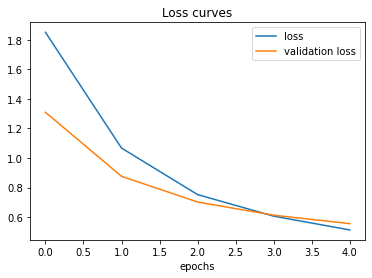

In [ ]:
plot_loss_curves(efficientnet_history)

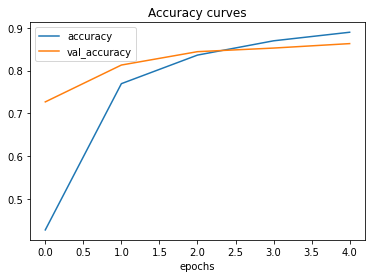

In [ ]:
plot_accuracy_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## **Compare our models on tensorboard**

tensorboard is used to visualize model and explore it.

In [ ]:
# upload to tensorboard

!tensorboard dev upload --logdir ./content/ \
  --name "Resnet v/s EfficientNet" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./content/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=DhARIPcBTtj7ThqQq6YSkWn9Dzimp0&prompt=consent&access_type=offline
En

In [ ]:
!tensorboard dev list


https://tensorboard.dev/experiment/wGvW97z6TQaVSYmBiK4XXw/
	Name                 Resnet v/s EfficientNet
	Description          [No Description]
	Id                   wGvW97z6TQaVSYmBiK4XXw
	Created              2022-01-21 14:59:22 (4 minutes ago)
	Updated              2022-01-21 14:59:24 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5841890
Total: 1 experiment(s)
